# Develop an NN model to learn Hardness Property of High entropy alloys

The dataset for this tutorial is taken from the following publication:

Wen, Cheng, et al. "Machine learning assisted design of high entropy alloys with desired property." Acta Materialia 170 (2019): 109-117 (https://doi.org/10.1016/j.actamat.2019.03.010).

This tutorial is similar to the previous GPR tutorial. Here, instead of Gaussian Process we will train a neural network model (NN) for high entropy alloy property prediction. We will achieve the following things:
1. Load high entropy alloy dataset
2. Use tensorflow + Keras library to build NN model

#### Library imports

In [ ]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import time

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.12.0


In [ ]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

### 1. Load data table

In [ ]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 10.8MB/s]


In [ ]:
data = pd.read_csv('alloy-confp-train-data_v2.csv')
data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


#### Seperate X and y data

In [ ]:
train_dataset = data.sample(frac=0.8, random_state=0)
val_dataset = data.drop(train_dataset.index)

In [ ]:
len(train_dataset), len(val_dataset)

(96, 24)

In [ ]:
Xcols = train_dataset.columns[train_dataset.columns.str.contains("C.")]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni'], dtype='object')

In [ ]:
train_X = train_dataset[Xcols]
val_X = val_dataset[Xcols]
train_X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
48,0.148936,0.212766,0.212766,0.000000,0.212766,0.212766
94,0.166667,0.000000,0.555556,0.000000,0.000000,0.277778
95,0.200000,0.200000,0.000000,0.200000,0.200000,0.200000
8,0.222222,0.222222,0.222222,0.111111,0.222222,0.000000
97,0.166667,0.166667,0.166667,0.000000,0.333333,0.166667
...,...,...,...,...,...,...
20,0.237500,0.050000,0.237500,0.000000,0.237500,0.237500
112,0.000000,0.250000,0.000000,0.250000,0.250000,0.250000
72,0.208333,0.000000,0.208333,0.208333,0.208333,0.166667
77,0.358974,0.128205,0.128205,0.128205,0.128205,0.128205


In [ ]:
train_y = train_dataset['HV']
val_y = val_dataset['HV']

train_y

48     338
94     371
95     536
8      639
97     510
      ... 
20     550
112    154
72     486
77     655
25     521
Name: HV, Length: 96, dtype: int64

 
---


### Define NN architechture

In [ ]:
input_layer = tf.keras.Input(shape=(len(Xcols),))
hl_1 = tf.keras.layers.Dense(10, activation='relu')(input_layer)
hl_2 = tf.keras.layers.Dense(5, activation='relu')(hl_1)
output_layer = tf.keras.layers.Dense(1, activation='relu')(hl_2)

nn_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')


nn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_12 (Dense)            (None, 10)                70        
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn_model.predict(train_X[:10])

1/1 [==============================] - 0s 159ms/step


array([[0.00685232],
       [0.        ],
       [0.01214707],
       [0.        ],
       [0.03773192],
       [0.        ],
       [0.        ],
       [0.01994049],
       [0.        ],
       [0.        ]], dtype=float32)

In [ ]:
history = nn_model.fit(
    train_X,
    train_y,
    epochs=200,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_data = (val_X, val_y))

Epoch 1/200
3/3 [==============================] - 1s 78ms/step - loss: 227554.0000 - val_loss: 204081.4219
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 224696.4375 - val_loss: 198843.6250
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 217594.4531 - val_loss: 187846.0781
Epoch 4/200
3/3 [==============================] - 0s 17ms/step - loss: 203548.7031 - val_loss: 168689.0469
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 180773.7969 - val_loss: 139618.8438
Epoch 6/200
3/3 [==============================] - 0s 17ms/step - loss: 146640.2969 - val_loss: 101133.1875
Epoch 7/200
3/3 [==============================] - 0s 16ms/step - loss: 105273.0703 - val_loss: 59155.0195
Epoch 8/200
3/3 [==============================] - 0s 16ms/step - loss: 64725.3281 - val_loss: 29419.0059
Epoch 9/200
3/3 [==============================] - 0s 17ms/step - loss: 41506.3438 - val_loss: 33259.9492
Epoch 10/200
3/3 [===============

In [ ]:
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  hist['rmse_train'] = np.sqrt(hist['loss'])
  hist['rmse_val'] = np.sqrt(hist['val_loss'])

  plt.plot(hist['rmse_train'], label='rmse_train')
  plt.plot(hist['rmse_val'], label='rmse_val')
  plt.yscale('log')
  plt.ylim(75,500)
  plt.xlabel('Epoch')
  plt.ylabel('Error [units]')
  plt.legend()
  plt.grid(True)

  return hist

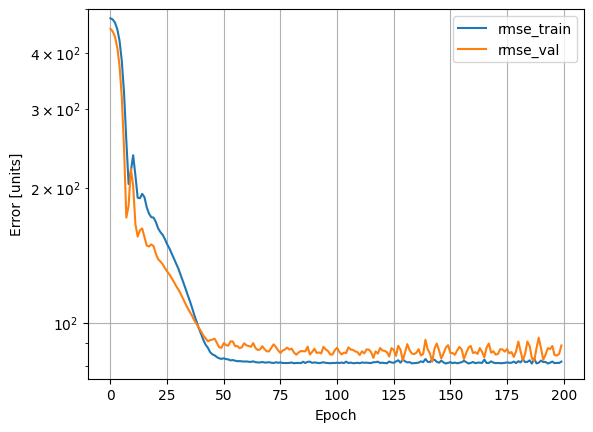

In [ ]:
hist = plot_loss(history)

In [ ]:
min_val_idx = hist['rmse_val'].argmin()

In [ ]:
hist.iloc[-1]['rmse_train']

81.88793731279199

In [ ]:
print(hist.loc[min_val_idx, 'rmse_val']), print(hist.iloc[-1]['rmse_val'])

81.80642106426457
88.95461942140076


(None, None)

In [ ]:
print(hist.loc[min_val_idx, 'rmse_train']), print(hist.iloc[-1]['rmse_train'])

82.78458255843898
81.88793731279199


(None, None)

### Question
1. The epoch with the lowest validation error is not the one at the end of the loop. How should we recover parameters (weights and biases) of the NN model associated with the lowest validation error. 

### Early stopping

In [ ]:
# This re-sets the NN weights, and is no more a good model

for l in nn_model.layers[1:]:
  l.set_weights([
    tf.random.normal(l.get_weights()[0].shape),
    tf.zeros(l.get_weights()[1].shape)
])

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=100,  # Number of epochs to wait before stopping
    verbose=1,  # Verbosity level (0: silent, 1: progress bar, 2: one line per epoch)
    restore_best_weights=True  # Whether to restore the weights from the epoch with the best monitored metric
)

# Train your model with the EarlyStopping callback
history = nn_model.fit(
    train_X, train_y,  # Training data
    validation_data=(val_X, val_y),  # Validation data
    epochs=500,  # Number of epochs to train for
    callbacks=[early_stopping],  # List of callbacks to use
    verbose=1
)

Epoch 1/500
3/3 [==============================] - 0s 37ms/step - loss: 227788.0469 - val_loss: 203289.7969
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 220503.3750 - val_loss: 180357.9219
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 176619.3125 - val_loss: 78831.3750
Epoch 4/500
3/3 [==============================] - 0s 25ms/step - loss: 64234.8320 - val_loss: 90015.0625
Epoch 5/500
3/3 [==============================] - 0s 18ms/step - loss: 75897.3438 - val_loss: 22357.7188
Epoch 6/500
3/3 [==============================] - 0s 20ms/step - loss: 35885.9297 - val_loss: 39232.2070
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 46772.3242 - val_loss: 27304.6504
Epoch 8/500
3/3 [==============================] - 0s 16ms/step - loss: 27282.4277 - val_loss: 17614.7715
Epoch 9/500
3/3 [==============================] - 0s 17ms/step - loss: 24836.5566 - val_loss: 22375.5059
Epoch 10/500
3/3 [=======================

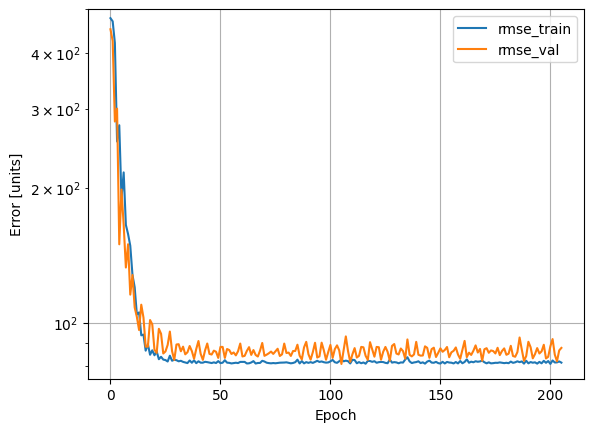

In [ ]:
hist = plot_loss(history)

### Various choices for ML model training

1. Activation function (tanh, sigmoid, relu)
2. NN hidden layers (1, 3, 10)
3. Batch normalization layers (True/False)
4. L2 Regularization (True/False)
5. Dropout (True/False)


In [ ]:
activation_funcs = ['sigmoid','tanh', 'relu']
nhidden_layers = [1,3,10]
bnorm = [True, False]
l2_reg = ['l2', None]
dropout = [True, False]

In [ ]:
def model(nn_params):

  input_layer = tf.keras.Input(shape=(len(Xcols),))
  hl = tf.keras.layers.Dense(50, activation=nn_params['act_func'], kernel_regularizer = nn_params['l2_reg'])(input_layer)
  for hl_idx in range(1, nn_params['nhidden_layer']):
    hl = tf.keras.layers.Dense(20, activation = nn_params['act_func'], kernel_regularizer = nn_params['l2_reg'])(hl)
    if (hl_idx%2 == 0) and (nn_params['dropout']):
      print('Adding dropout')
      hl = tf.keras.layers.Dropout(0.3)(hl)
    if (hl_idx%2 == 1) and (nn_params['bnorm']):
    #if nn_params['bnorm']:      
      print('Adding bnorm')
      hl = tf.keras.layers.BatchNormalization()(hl)
  output_layer = tf.keras.layers.Dense(1, activation = 'linear', kernel_regularizer = nn_params['l2_reg'])(hl)

  nn_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  nn_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss='mean_squared_error')

  nn_model.summary()

  return nn_model

In [ ]:
nn_params = {
  'act_func' : 'relu',
  'nhidden_layer' : 10,
  'bnorm' : True,
  #'l2_reg' : 'l2',
  'l2_reg' : None,
  'dropout' : True,
}

In [ ]:
ml = model(nn_params)

Adding bnorm
Adding dropout
Adding bnorm
Adding dropout
Adding bnorm
Adding dropout
Adding bnorm
Adding dropout
Adding bnorm
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_79 (Dense)            (None, 50)                350       
                                                                 
 dense_80 (Dense)            (None, 20)                1020      
                                                                 
 batch_normalization_29 (Bat  (None, 20)               80        
 chNormalization)                                                
                                                                 
 dense_81 (Dense)            (None, 20)                420       
                                                                 

In [ ]:
%%time
history = ml.fit(
    train_X,
    train_y,
    epochs=300,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_data = (val_X, val_y))

Epoch 1/300
3/3 [==============================] - 5s 161ms/step - loss: 227980.7656 - val_loss: 205807.9844
Epoch 2/300
3/3 [==============================] - 0s 20ms/step - loss: 227730.6719 - val_loss: 205648.9219
Epoch 3/300
3/3 [==============================] - 0s 22ms/step - loss: 227435.5781 - val_loss: 205462.2344
Epoch 4/300
3/3 [==============================] - 0s 22ms/step - loss: 227129.5469 - val_loss: 205258.6250
Epoch 5/300
3/3 [==============================] - 0s 33ms/step - loss: 226720.3281 - val_loss: 205070.1719
Epoch 6/300
3/3 [==============================] - 0s 20ms/step - loss: 226588.9375 - val_loss: 204909.8281
Epoch 7/300
3/3 [==============================] - 0s 20ms/step - loss: 225992.2969 - val_loss: 204743.3281
Epoch 8/300
3/3 [==============================] - 0s 31ms/step - loss: 225487.8750 - val_loss: 204478.2031
Epoch 9/300
3/3 [==============================] - 0s 20ms/step - loss: 224787.8594 - val_loss: 204020.5469
Epoch 10/300
3/3 [=========

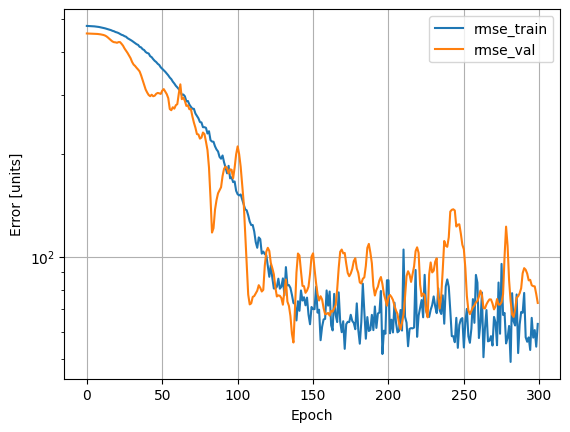

In [ ]:
hist = plot_loss(history)

In [ ]:
hist['rmse_val'].min()

55.96207560705732

#### NOTE
The best error obtained from GPR in tutorial 8-9 was 51.0018 units

### Question
2. Play with different concepts of NN, such as number of layers, Dropouts, activation functions, and others discussed in the class to build a NN with lowest validation error. Discuss which combination of factors allowed you to build a good NN model.